In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

folder_path = '/content/drive/MyDrive/Machine Learning Project/Audios/'
files = os.listdir(folder_path)
files_path = [os.path.join(folder_path, file) for file in files]

In [3]:
def extract_gender(file_name):
    file_name_lower = file_name.lower()
    if 'female' in file_name_lower:
        return 'female'
    elif 'male' in file_name_lower:
        return 'male'
    else:
        return None

genders = [extract_gender(file) for file in files]

In [4]:
import re

def extract_student_id(file_name, pattern=r"\d{9}"):
    match = re.search(pattern, file_name)
    if match:
        return match.group()
    else:
        return None

student_ids = [extract_student_id(file) for file in files]

In [5]:
import librosa

def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=target_sr, mono=True)  # Resampling if needed
    return audio, sr

In [6]:
import numpy as np
import scipy.signal as signal

def reduce_noise(audio, sr):
    freqs, times, Sxx = signal.spectrogram(audio, sr)
    noise_threshold = np.median(Sxx, axis=1)[:, np.newaxis]
    Sxx_denoised = np.maximum(Sxx - noise_threshold, 0)
    return librosa.istft(Sxx_denoised)

In [7]:
def bandpass_filter(audio, sr, lowcut=300, highcut=3400, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, audio)

In [8]:
def frame_audio(audio, frame_size=2048, hop_size=512):
    return librosa.util.frame(audio, frame_length=frame_size, hop_length=hop_size).T

In [9]:
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

In [10]:
def preprocess_audio(file_path):
    audio, sr = load_audio(file_path)
    audio = reduce_noise(audio, sr)
    audio = bandpass_filter(audio, sr)
    frames = frame_audio(audio)
    frames = np.array([normalize_audio(frame) for frame in frames])
    return frames, sr

In [11]:
from librosa.feature import (
    mfcc,
    spectral_centroid,
    spectral_bandwidth,
    spectral_contrast,
    melspectrogram,
    zero_crossing_rate,
    chroma_stft
)

def extract_features(frame, sr):
    features = {
        "MFCC": mfcc(y=frame, sr=sr, n_mfcc=8),
        "Spectral Centroid": spectral_centroid(y=frame, sr=sr),
        "Spectral Bandwidth": spectral_bandwidth(y=frame, sr=sr),
        "Spectral Contrast": spectral_contrast(y=frame, sr=sr),
        "Log Mel Spectrogram": librosa.power_to_db(melspectrogram(y=frame, sr=sr, n_mels=10)),
        "Zero Crossing Rate": zero_crossing_rate(y=frame),
        "Chroma Features": chroma_stft(y=frame, sr=sr, n_chroma=6),
        "Energy": np.sum(frame ** 2) / len(frame)
    }
    return features

In [12]:
from tqdm import tqdm
import pandas as pd

def process_audio_files(indices, labels, name):
    all_features, all_labels = [], []

    for i in tqdm(indices):
        frames, sr = preprocess_audio(files_path[i])
        if np.any(np.isnan(frames)):
            continue

        for frame in frames:
            features = extract_features(frame, sr)
            all_features.append(features)
            all_labels.append(labels[i])

    df = pd.DataFrame(all_features)

    features = df.drop(columns='Energy').map(lambda x: x.flatten())
    features['Energy'] = df['Energy']
    features = np.vstack(features.apply(np.hstack, axis=1).to_numpy())

    np.save(f'/content/drive/MyDrive/Machine Learning Project/features {name}.npy', features)

    np.savez_compressed(f'/content/drive/MyDrive/Machine Learning Project/dataset {name}.npz',
        features=features,
        labels=np.array(all_labels)
    )

In [ ]:
import random

for i in range(3):
    selected_indices = set()
    while len(selected_indices) < 6:
        index = random.randint(0, len(student_ids) - 1)
        if student_ids[index] != None:
            selected_indices.add(index)

    process_audio_files(selected_indices, student_ids, f'authentication {i + 1}')

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 83%|████████▎ | 5/6 [05:14<01:12, 72.13s/it]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 17%|█▋        | 1/6 [00:35<02:56, 35.22s/it]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 6/6 [06:18<00:00, 63.11s/it]


In [13]:
n = len(files) // 8
male_count, female_count = 0, 0
selected_indices = []

for i in range(len(genders)):
    if genders[i] == 'male' and male_count < n:
        selected_indices.append(i)
        male_count += 1
    elif genders[i] == 'female' and female_count < n:
        selected_indices.append(i)
        female_count += 1

process_audio_files(selected_indices, genders, 'gender')

  4%|▍         | 8/204 [02:41<57:18, 17.54s/it]  /usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 204/204 [1:03:23<00:00, 18.64s/it]


In [ ]:
import matplotlib.pyplot as plt

def plot_spectrogram(audio, sr):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

def plot_mel_spectrogram(audio, sr):
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=10)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

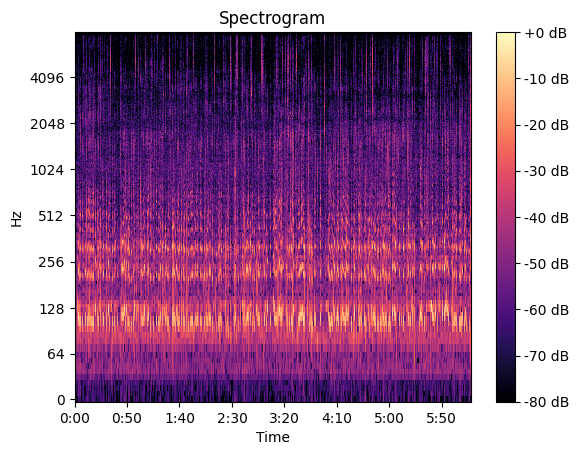

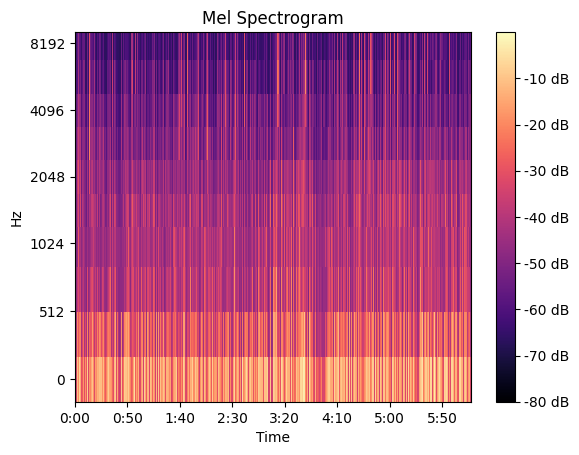

In [ ]:
audio, sr = load_audio(files_path[0])
plot_spectrogram(audio, sr)
plot_mel_spectrogram(audio, sr)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_features(features, labels, method):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_features = reducer.fit_transform(features)

    unique_labels = np.unique(labels)
    colors = plt.get_cmap('tab10', len(unique_labels))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1],
                    label=label, alpha=0.6, color=colors(i))

    plt.title(f'Feature Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


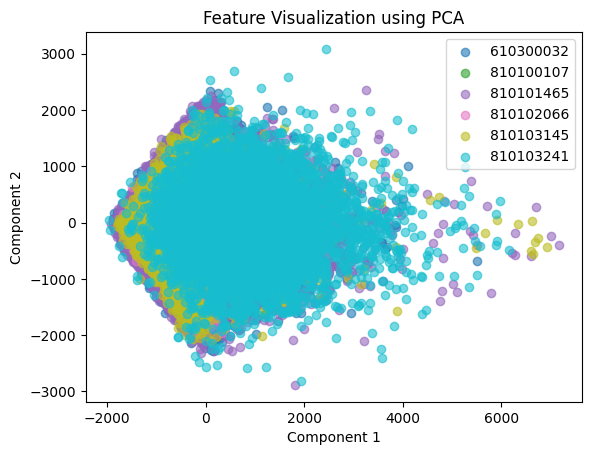

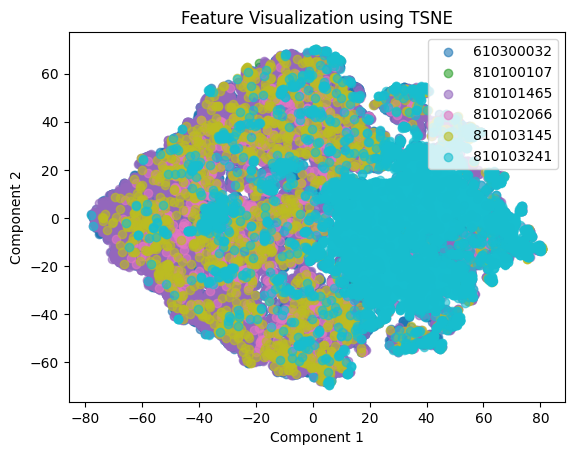

In [ ]:
import random

all_features, all_labels = [], []
for _ in range(6):
    index = random.randint(0, len(student_ids) - 1)
    file_path = files_path[index]
    frames, sr = preprocess_audio(file_path)
    for frame in frames:
        features = extract_features(frame, sr)
        features = np.hstack([feature.flatten() for feature in features.values()])
        all_features.append(features)
        all_labels.append(student_ids[index])
all_features, all_labels = np.array(all_features), np.array(all_labels)

visualize_features(all_features, all_labels, 'pca')
visualize_features(all_features, all_labels, 'tsne')